<a href="https://colab.research.google.com/github/raminnourizade/Proposal/blob/main/eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.7 MB/s eta 0:00:00


In [ ]:
import gdown
import os
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import keras
from tensorflow.keras import layers
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from scipy import signal

from tensorflow.keras import regularizers



In [ ]:
def load_data():
  path="dataset"
  if not os.path.exists(path):
      os.mkdir(path)
      print(f"Folder {path} created!")

      file_id = "1hG5v_COjPNzejRaL9XJAFERee9i2_V04"  # Replace this with your file's ID
      output_file = path+"/eeg.zip"  # Replace "data_file.ext" with the desired output filename and extension
      gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
      !unzip "dataset/eeg.zip" -d "dataset"
      os.remove("dataset/eeg.zip")

  else:
      print(f"Folder {path} already exists")


  ds_dir = '/content/dataset/'
  scaler = StandardScaler()
  all_eeg=[]

  for (i, item) in enumerate(glob.glob(ds_dir + '*.edf')):
    print(item)
    raw = mne.io.read_raw_edf(item)
    # Filter EEG channels ('P3' and 'C3')
    eeg_channels = [ch for ch in raw.info['ch_names'] if ch in channels]
    if len(eeg_channels) != len(channels):
        print(f"Error: channels not found in {item}. Skipping...")
        continue

    # Create a new Raw object with only EEG channels
    raw = raw.copy().pick_channels(eeg_channels)

    # Apply bandpass filter (example: 0.1 Hz - 40 Hz)
    raw.load_data()  # Load the data into memory
    raw.filter(l_freq=0.1, h_freq=40)
   # print("mean of data is  {:.6f}".format(np.mean(np.mean(raw))))
    # Segment data into epochs (e.g., 1-second epochs)
    events = mne.make_fixed_length_events(raw, duration=1.0)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=1.0, baseline=None)

    X = epochs.get_data()
    # Standardize features (Z-score normalization)
    n_samples, n_channels, n_time_points = X.shape

    # Reshape to 2D (n_samples x (n_channels * n_time_points))
    #X_reshaped = X.reshape(n_samples, -1)
    X_reshaped=X
    # Apply StandardScaler

    # Compute mean and standard deviation along the time axis (axis 2)
    mean = np.mean(X_reshaped, axis=(0, 1, 2))
    std = np.std(X_reshaped, axis=(0, 1, 2))
    print("mean of data is  {:.6f}".format(np.mean(mean)))
     # Perform scaling
    eeg_data_scaled = (X_reshaped - mean) / std
    X_scaled = eeg_data_scaled

    all_eeg.append(X_scaled)


  #all_eeg=np.array(all_eeg)

  lb=LabelBinarizer()
  all_labels = pd.read_excel("/content/dataset/states.xlsx",usecols=["status"])
  all_labels=lb.fit_transform(all_labels)


  return all_eeg, all_labels, n_samples, n_channels ,n_time_points
  #return  X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points

In [ ]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Patch creation
    patch_size = 4
    #patches = layers.Conv2D(filters=64, kernel_size=patch_size, strides=patch_size, activation='relu')(inputs)
    patches = layers.Conv2D(filters=16, kernel_size=patch_size, strides=patch_size, activation='relu')(inputs)

    # Flatten patches
    flattened_patches = layers.Flatten()(patches)

    # MLP head
    #mlp_output = layers.Dense(256, activation='gelu')(flattened_patches)
    mlp_output= layers.Dense(32, kernel_regularizer=regularizers.l2(0.01))(flattened_patches)


    mlp_output = layers.Dropout(0.2)(mlp_output)

    # Classification head
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(mlp_output)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]  # Assuming RGB images (3 channels)

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        patches = tf.image.extract_patches(images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patches = tf.reshape(patches, (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels))

        return patches


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [ ]:
def apply_augmentation(data, noise_level=0.2):
  np.random.seed(42)
  noise = np.random.normal(scale=noise_level, size=np.shape(data))
  augmented_data=data + noise

  return np.array(augmented_data)

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [ ]:
channels= ['T3', 'T5', 'T4', 'T6','Fp2','F3','Fz','Pz','C3','P3','O1','O2']
all_eeg, all_labels, n_samples, n_channels ,n_time_points = load_data()
#X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points = load_data()


Folder dataset created!


Downloading...
From (original): https://drive.google.com/uc?id=1hG5v_COjPNzejRaL9XJAFERee9i2_V04
From (redirected): https://drive.google.com/uc?id=1hG5v_COjPNzejRaL9XJAFERee9i2_V04&confirm=t&uuid=459054a1-5b85-43be-a8a7-da4c86efd5c8
To: /content/dataset/eeg.zip
100%|██████████| 383M/383M [00:03<00:00, 113MB/s]


Archive:  dataset/eeg.zip
  inflating: dataset/15.edf          
  inflating: dataset/16.edf          
  inflating: dataset/17.edf          
  inflating: dataset/18.edf          
  inflating: dataset/19.edf          
  inflating: dataset/20.edf          
  inflating: dataset/21.edf          
  inflating: dataset/22.edf          
  inflating: dataset/23.edf          
  inflating: dataset/24.edf          
  inflating: dataset/25.edf          
  inflating: dataset/26.edf          
  inflating: dataset/27.edf          
  inflating: dataset/1.edf           
  inflating: dataset/2.edf           
  inflating: dataset/3.edf           
  inflating: dataset/4.edf           
  inflating: dataset/5.edf           
  inflating: dataset/6.edf           
  inflating: dataset/7.edf           
  inflating: dataset/8.edf           
  inflating: dataset/9.edf           
  inflating: dataset/10.edf          
  inflating: dataset/11.edf          
  inflating: dataset/12.edf          
  inflating: dataset/13.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_eeg, all_labels, test_size=0.2, random_state=42)

In [ ]:
print( "n_samples= {} and  n_channels = {} and n_time_points= {}".format(n_samples, n_channels ,n_time_points))

n_samples= 1810 and  n_channels = 12 and n_time_points= 257


In [ ]:
for x in range(len(X_train)):
  X_train[x]=X_train[x][0:1802,0:12,0:257]
for x in range(len(X_test)):
  X_test[x]=X_test[x][0:1802,0:12,0:257]

In [ ]:
X_train=np.stack( X_train, axis=0 )
X_train = np.array(X_train)
#X_train_reshaped = X_train.reshape(len(X_train), n_channels, n_time_points, 1)

X_test=np.stack( X_test, axis=0 )
X_test = np.array(X_test)# Reshape the arrays
#X_test_reshaped = X_test.reshape(len(X_test), n_channels, n_time_points, 1)




In [ ]:
np.mean(X_train)


-0.0002385897377081566

In [ ]:
np.shape(X_train)

(21, 1802, 12, 257)

In [ ]:
mlp_head_units =[16, 8] #=[32, 16]#[64, 32] [128, 64] #   [256, 128]
input_shape =np.shape(X_train[0])#  (1802, 12, 257)

In [ ]:
print("Shapes of training data and labels:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("Shapes of testing data and labels:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Shapes of training data and labels:
X_train shape: (21, 1802, 12, 257)
y_train shape: (21, 1)
Shapes of testing data and labels:
X_test shape: (6, 1802, 12, 257)
y_test shape: (6, 1)


In [ ]:
lr_callback = LearningRateScheduler(lr_scheduler)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
X_train_augmented = apply_augmentation(X_train)
X_test_augmented = apply_augmentation(X_test)

In [ ]:
vit_model = create_vit_model(input_shape, 2)
vit_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1802, 12, 257)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, 450, 3, 16)        65808     
                                                                 
 flatten_2 (Flatten)         (None, 21600)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                691232    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 757,106
Trainable params: 757,106
Non-trainab

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)#
vit_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])  # Compile the model with the custom optimizer

In [ ]:
y_test

array([[0],
       [1],
       [0],
       [0],
       [1],
       [0]])

Epoch 1/20
2/2 [==============================] - 4s 1s/step - loss: 4.6367 - accuracy: 0.5714 - val_loss: 10.1852 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 2s 845ms/step - loss: 2.7006 - accuracy: 0.8095 - val_loss: 3.1834 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 1s 650ms/step - loss: 0.6583 - accuracy: 1.0000 - val_loss: 5.8248 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 2s 693ms/step - loss: 1.5580 - accuracy: 0.9524 - val_loss: 3.1317 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 0.6798 - accuracy: 1.0000 - val_loss: 11.0394 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 2s 827ms/step - loss: 2.4448 - accuracy: 0.9048 - val_loss: 3.4578 - val_accuracy: 0.6667 - lr: 9.0484e-04
Epoch 7/20
2/2 [==============================] - 2s 638ms/step - loss: 0.6947 - a

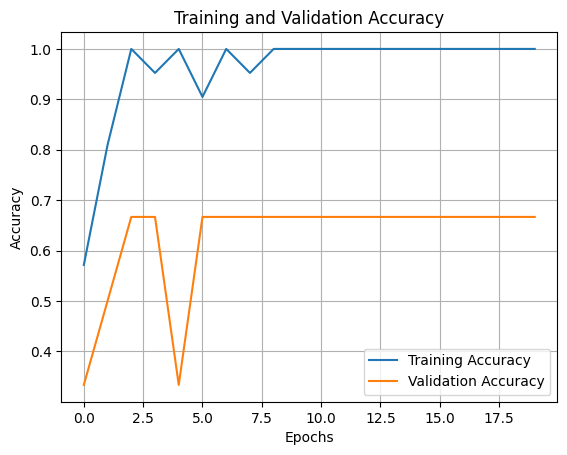

In [ ]:
history = vit_model.fit(X_train_augmented, y_train, batch_size=16, epochs=20,
                        validation_data=(X_test_augmented, y_test), callbacks=[lr_callback])
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = vit_model.evaluate(X_test_augmented, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 0s 260ms/step - loss: 31.8889 - accuracy: 0.5000
Test Loss: 31.8889, Test Accuracy: 0.5000
